In [ ]:
#Importing necessary libraries
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
 


In [ ]:
#mounting google drive 
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Setting train and test directory
#Setting the categories and mean weight
train_directory = "/content/gdrive/My Drive/DSP Final Project/Fruit/Train"
test_directory = "/content/gdrive/My Drive/DSP Final Project/Fruit/Test"
categories = ["Avocado","Gala_Apple","Green_Apple","Pears","Lime","Lemon","Mango","Red_Apple","Tomato_On_The_Vine","Roma_Tomato","Vine_Ripe_Tomato"]
meanwgt = [150,90,85,178,45,60,200, 70,90, 63, 150 ]

In [ ]:
#Creating a dictionary which has index and fruit name as key & value respectively
produce = {}
for index, value in enumerate(categories):
    produce[index] = value

In [ ]:
#Creating training data which has images and weights
#randomly generating weights based on the mean weight 
trainval_data = []
IMG_SIZE = 150

def create_trainval_data(category,meanwght):
  path = os.path.join(train_directory, category)
  class_num = categories.index(category)
  lower = meanwght-5
  upper = meanwght+5
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    new_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    weight = np.random.randint(lower, upper)
    trainval_data.append([new_img_array, class_num, weight])

In [ ]:
for category,weight in zip(categories,meanwgt) :
  create_trainval_data(category,weight)

In [ ]:
#Creating test data which has images and weights
test_data = []

def create_test_data(category,meanwght):
   path = os.path.join(test_directory, category)
   class_num = categories.index(category)
   lower = meanwght-5
   upper = meanwght+5
   for img in os.listdir(path):
      img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
      img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
      new_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      weight = np.random.randint(lower, upper)
      test_data.append([new_img_array, class_num, weight])  

In [ ]:
for category,weight in zip(categories,meanwgt) :
  create_test_data(category,weight)

In [ ]:
print(np.array(trainval_data).shape)
print(np.array(test_data).shape)

(868, 3)
(115, 3)


In [ ]:
#shuffling the training data
random.seed(42)
random.shuffle(trainval_data)

In [ ]:
#Creating the train and test variables
X_train = []
y_train = []
X_train_weight = []

X_test = []
y_test = []
X_test_weight = []

In [ ]:
for features, labels, weights in trainval_data:
    X_train.append(features)
    X_train_weight.append(weights)
    y_train.append(labels)

In [ ]:
for features, labels, weights in test_data:
    X_test.append(features)
    X_test_weight.append(weights)
    y_test.append(labels)

In [ ]:
#Converting the test and test variables to arrays
X_train = np.array(X_train)
X_train_weight = np.array(X_train_weight)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_test_weight = np.array(X_test_weight)
y_test = np.array(y_test)

In [ ]:
#Shape of train and test data
print(X_train.shape)
print(X_train_weight.shape)
print(y_train.shape)
print(X_test.shape)
print(X_test_weight.shape)
print(y_test.shape)

(868, 150, 150, 3)
(868,)
(868,)
(115, 150, 150, 3)
(115,)
(115,)


Name: Roma_Tomato
Weight:64


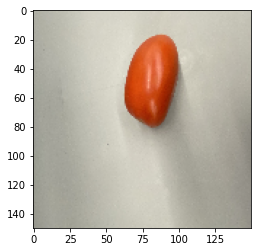

In [ ]:
#Checking images in training data
i = 50
plt.imshow(X_train[i])
print("Name:",produce.get(y_train[i]))
print("Weight:" + str(X_train_weight[i]))


Name: Gala_Apple
Weight:92


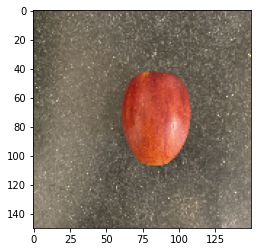

In [ ]:
#Checking images in test data
i=10
plt.imshow(X_test[i])
print("Name:",produce.get(y_test[i]))
print("Weight:" + str(X_test_weight[i]))

In [ ]:
#Scaling the images
X_train= X_train/255
X_test= X_test/255

In [ ]:
acc_per_fold = []
loss_per_fold = []
kfold = KFold(n_splits=3, shuffle=True)

MODEL WITH WEIGHT


In [ ]:
fold_no = 1
input_images = Input(shape=(150,150,3))
input_weights = Input(shape=(1))
for train, test in kfold.split(X_train, y_train): 

  #Convolutional layers
  conv1 = Conv2D(60, (3,3), activation='relu',padding='same')(input_images)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(32, (3,3), activation='relu',padding='same')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(32, (3,3), activation='relu',padding='same')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(64, (3,3), activation='relu',padding='same')(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  flat1 = Flatten()(pool4)
  # merge flattened layer with weights
  merge = concatenate([flat1,input_weights])
  # interpretation layer
  dense1 = Dense(64, activation='relu')(merge)
  dropout = Dropout(0.2)(dense1)
  # using softmax since it is multiclass
  output = Dense(11, activation='softmax')(dropout)
  model1 = Model(inputs=[input_images,input_weights], outputs=output)
  # summarize layers
  print(model1.summary())  
  #es = keras.callbacks.EarlyStopping(monitor="loss")
  model1.compile(loss='sparse_categorical_crossentropy',
  optimizer=keras.optimizers.Adam(lr=0.001),
  metrics='accuracy')
  print('-----------------------------------')
  print(f'Training for fold{fold_no}..')
  history1 = model1.fit(x=[X_train,X_train_weight], y=y_train, epochs=25,verbose=1)
  scores = model1.evaluate(x=[X_test,X_test_weight],y= y_test, verbose= 0)
  print(f'score for {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
  
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  fold_no = fold_no + 1

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 60) 1680        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 75, 75, 60)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 75, 75, 32)   17312       max_pooling2d[0][0]              
_______________________________________________________________________________________

In [ ]:
#Getting the scores
scores = model1.evaluate(x=[X_test,X_test_weight],y= y_test, verbose= 0)
print(f'Loss is {scores[0]}, and ACCURACY is {scores[1]} ')

Loss is 0.2332625687122345, and ACCURACY is 0.9217391014099121 


In [ ]:
#Getting the images the model predicted incorrectly
pred = model1.predict(x = [X_test,X_test_weight])
predictions = []
for i in pred:
  predictions.append(np.argmax(i))
incorrects = np.nonzero(y_test != predictions)
print(incorrects)

(array([ 14,  17,  19,  28,  36,  92,  94,  95, 101]),)


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.75      0.86        12
           2       0.89      0.89      0.89         9
           3       1.00      0.89      0.94         9
           4       1.00      1.00      1.00        13
           5       0.94      1.00      0.97        16
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        11
           8       0.83      0.71      0.77        14
           9       0.00      0.00      0.00         0
          10       1.00      1.00      1.00        10

    accuracy                           0.92       115
   macro avg       0.88      0.84      0.86       115
weighted avg       0.96      0.92      0.94       115



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actual : Green_Apple
Predicted : Pears


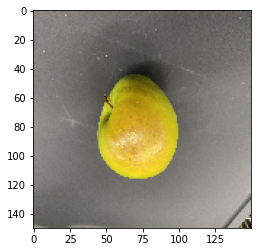

In [ ]:
#Viewing the images the model failed to recognise
i =  28
plt.imshow(X_test[i])
print("Actual : " + str(produce.get(y_test[i])))
print("Predicted : " + str(produce.get(np.argmax(pred[i]))))

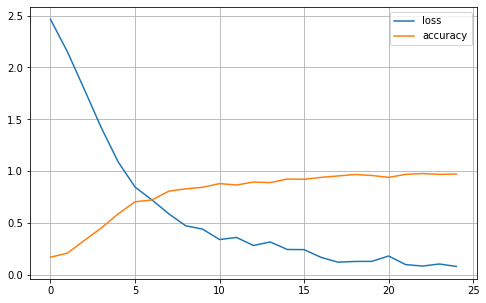

In [ ]:
pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

MODEL WITHOUT WEIGHT

In [ ]:
fold_no = 1
input_images = Input(shape=(150,150,3))
for train, test in kfold.split(X_train, y_train): 

  #Convolutional layers
  conv1 = Conv2D(60, (3,3), activation='relu',padding='same')(input_images)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(32, (3,3), activation='relu',padding='same')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(32, (3,3), activation='relu',padding='same')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(64, (3,3), activation='relu',padding='same')(pool3)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  flat1 = Flatten()(pool4)
  # interpretation layer
  dense1 = Dense(64, activation='relu')(flat1)
  dropout = Dropout(0.2)(dense1)
  # using softmax since it is multiclass
  output = Dense(11, activation='softmax')(dropout)
  model2 = Model(inputs=[input_images], outputs=output)
  # summarize layers
  print(model2.summary())  
  #es = keras.callbacks.EarlyStopping(monitor="loss")
  model2.compile(loss='sparse_categorical_crossentropy',
  optimizer=keras.optimizers.Adam(lr=0.001),
  metrics='accuracy')
  print('-----------------------------------')
  print(f'Training for fold{fold_no}..')
  history2 = model2.fit(x=[X_train], y=y_train, epochs=25,verbose=1)
  scores = model2.evaluate(x=[X_test],y= y_test, verbose= 0)
  print(f'score for {fold_no}: {model2.metrics_names[0]} of {scores[0]}; {model2.metrics_names[1]} of {scores[1]*100}%')
  
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  fold_no = fold_no + 1

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 150, 150, 60)      1680      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 60)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 32)        17312     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 18, 32)       

In [ ]:
scores = model2.evaluate(x=[X_test,X_test_weight],y= y_test, verbose= 0)
print(f'Loss is {scores[0]}, and ACCURACY is {scores[1]} ')

Loss is 0.48067545890808105, and ACCURACY is 0.834782600402832 


In [ ]:
pred = model2.predict(x = [X_test,X_test_weight])
predictions = []
for i in pred:
  predictions.append(np.argmax(i))
incorrects = np.nonzero(y_test != predictions)
print(incorrects)

(array([ 14,  16,  17,  18,  19,  20,  28,  30,  31,  32,  36,  44,  51,
        53,  75,  95,  98, 101, 105]),)


In [ ]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.50      0.67        12
           2       0.62      0.89      0.73         9
           3       0.83      0.56      0.67         9
           4       1.00      0.85      0.92        13
           5       1.00      0.94      0.97        16
           6       0.92      0.92      0.92        12
           7       1.00      1.00      1.00        11
           8       0.61      0.79      0.69        14
           9       0.00      0.00      0.00         0
          10       1.00      0.90      0.95        10

    accuracy                           0.83       115
   macro avg       0.81      0.76      0.77       115
weighted avg       0.89      0.83      0.85       115



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Actual : Mango
Predicted : Green_Apple


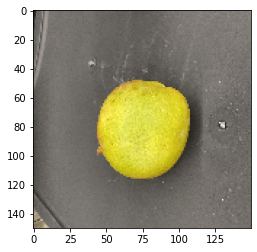

In [ ]:
#image which the model without weights got wrong
i =  75
plt.imshow(X_test[i])
print("Actual : " + str(produce.get(y_test[i])))
print("Predicted : " + str(produce.get(np.argmax(pred[i]))))

Actual : Mango
Predicted : Mango


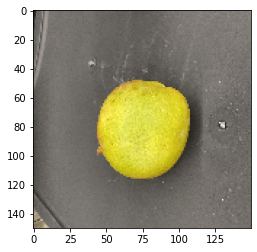

In [ ]:
#the same image which the model with weights got right
i =  75
plt.imshow(X_test[i])
print("Actual : " + str(produce.get(y_test[i])))
print("Predicted : " + str(produce.get(np.argmax(pred[i]))))

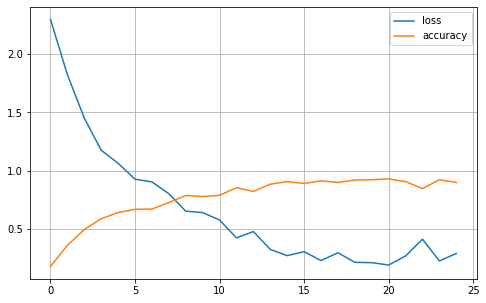

In [ ]:
#learning of model2
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()